# Imports and constants

In [ ]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from tensorflow.python.keras.preprocessing import dataset_utils
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
from google.colab import drive

IMAGE_WIDTH=224   # Resizing dimensions
IMAGE_HEIGHT=224
BATCH_SIZE=64

2.7.0


#Connection to Google Drive

In [ ]:
drive.mount('/gdrive')

Mounted at /gdrive


# Dataset 

Make train reproducible

In [ ]:
tf.keras.utils.set_random_seed(123)

Download of the dataset from Kaggle

In [ ]:
! pip install -q kaggle

from google.colab import files
_ = files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d mikoaro/distracteddriver --unzip

100% 3.99G/4.01G [01:41<00:00, 52.2MB/s]
100% 4.01G/4.01G [01:41<00:00, 42.4MB/s]


Create training set and test set folders

In [ ]:
class_labels = [0,1,2,3,4,5,6,7,8,9]
os.mkdir("/gdrive/MyDrive/Progetto Computational Intelligence/train/10-class/")
os.mkdir("/gdrive/MyDrive/Progetto Computational Intelligence/test/10-class/")
for i in class_labels:
  os.mkdir("/gdrive/MyDrive/Progetto Computational Intelligence/train/10-class/c"+str(i))
  os.mkdir("/gdrive/MyDrive/Progetto Computational Intelligence/test/10-class/c"+str(i))

In [ ]:
labels=[]
for dir in range(10):
  images = os.listdir("/content/distracted-driver-detection/train/c"+str(dir))
  labels.append(len(images))

We create a histogram of the class types

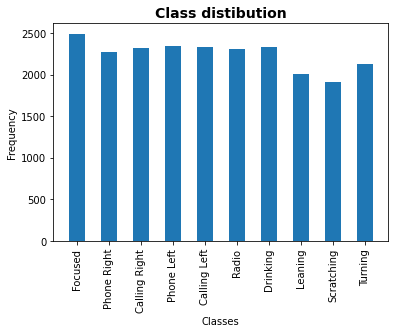

In [ ]:
classes = ['Focused', 'Phone Right', 'Calling Right', 'Phone Left','Calling Left', 'Radio', 'Drinking', 'Leaning', 'Scratching', 'Turning']
plt.bar(classes, labels, width=0.5, align='center')
plt.xlabel('Classes')
plt.ylabel('Frequency')
ax = plt.gca()
ax.set_xticklabels(labels=classes,rotation=90);
plt.title('Class distibution', fontdict=dict(fontsize=14, fontweight='bold'))
plt.show()

To reduce the computational effort, we had to select only 50% of the images present in the smallest category.

In [ ]:
labels=[]
for dir in class_labels:
  images = os.listdir("/content/distracted-driver-detection/train/c"+str(dir))
  labels.append(len(images))
min_class_size=round(min(labels)/2)

We perform the rebalancing of the dataset and split the data in training and test set (80%-20%), such that the 10 classes have the same cardinality. This will be useful to apply K-fold-crossvalidation

In [ ]:
for dir in class_labels:
  images = os.listdir("/content/distracted-driver-detection/train/c"+str(dir))
  selected_indexes = np.arange(min_class_size)
  random.Random(4).shuffle(selected_indexes)
  for index in selected_indexes[:int(min_class_size*0.8)]:
    shutil.move("/content/distracted-driver-detection/train/c"+str(dir)+"/"+images[index],"/gdrive/MyDrive/Progetto Computational Intelligence/train/10-class/c"+str(dir)+"/"+images[index])
  
  for index in selected_indexes[int(min_class_size*0.8):min_class_size]:
    shutil.move("/content/distracted-driver-detection/train/c"+str(dir)+"/"+images[index],"/gdrive/MyDrive/Progetto Computational Intelligence/test/10-class/c"+str(dir)+"/"+images[index])

Clean up the old dataset

In [ ]:
shutil.rmtree("/content/distracted-driver-detection/")

Here we show some images belonging to the classes we neglected before.

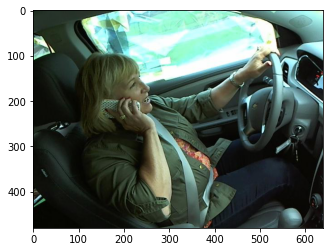

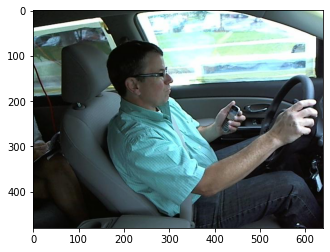

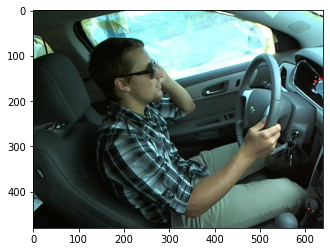

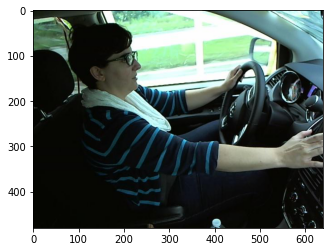

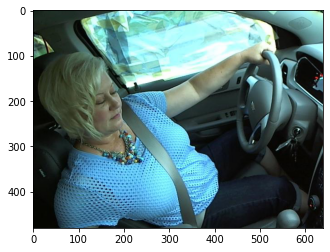

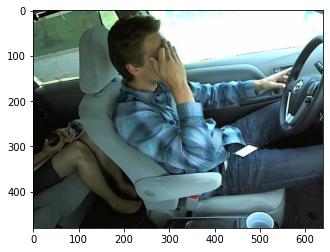

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_2= os.listdir("/gdrive/MyDrive/Progetto Computational Intelligence/train/10-class/c2")[0]
img_3 = os.listdir("/gdrive/MyDrive/Progetto Computational Intelligence/train/10-class/c3")[0]
img_4 = os.listdir("/gdrive/MyDrive/Progetto Computational Intelligence/train/10-class/c4")[0]
img_5 = os.listdir("/gdrive/MyDrive/Progetto Computational Intelligence/train/10-class/c5")[0]
img_7 = os.listdir("/gdrive/MyDrive/Progetto Computational Intelligence/train/10-class/c7")[0]
img_8 = os.listdir("/gdrive/MyDrive/Progetto Computational Intelligence/train/10-class/c8")[0]


image = Image.open("/gdrive/MyDrive/Progetto Computational Intelligence/train/10-class/c2/" + img_2,'r')
plt.imshow(image)
plt.show()
image = Image.open("/gdrive/MyDrive/Progetto Computational Intelligence/train/10-class/c3/" + img_3,'r')
plt.imshow(image)
plt.show()
image = Image.open("/gdrive/MyDrive/Progetto Computational Intelligence/train/10-class/c4/" + img_4,'r')
plt.imshow(image)
plt.show()
image = Image.open("/gdrive/MyDrive/Progetto Computational Intelligence/train/10-class/c5/" + img_5,'r')
plt.imshow(image)
plt.show()
image = Image.open("/gdrive/MyDrive/Progetto Computational Intelligence/train/10-class/c7/" + img_7,'r')
plt.imshow(image)
plt.show()
image = Image.open("/gdrive/MyDrive/Progetto Computational Intelligence/train/10-class/c8/" + img_8,'r')
plt.imshow(image)
plt.show()


In [ ]:
print("The width and height of the images are "+ str(image.size))
print ("Every class contains ", len(os.listdir("/gdrive/MyDrive/Progetto Computational Intelligence/train/10-class/c0")), " training images")
print ("Every class contains ", len(os.listdir("/gdrive/MyDrive/Progetto Computational Intelligence/test/10-class/c0")), " testing images")

The width and height of the images are (640, 480)
Every class contains  764  training images
Every class contains  192  testing images


# Training and Validation Set

Load the entire training set and split into train and validation sets.

In [ ]:
train_set = image_dataset_from_directory(
  '/gdrive/MyDrive/Progetto Computational Intelligence/train/10-class',
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
  seed = 123, # Seed setting to make sure that there is no overlap between the training and validation subset.
  validation_split = 0.2,
  subset = 'training')

validation_set = image_dataset_from_directory(
  '/gdrive/MyDrive/Progetto Computational Intelligence/train/10-class',
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
  seed = 123,
  validation_split = 0.2,
  subset = 'validation')

Found 7640 files belonging to 10 classes.
Using 6112 files for training.
Found 7640 files belonging to 10 classes.
Using 1528 files for validation.


We could also visualize the images randomly transformed with a Data Augmentation. This simulates possible positioning variations of the camera in the cockpit

In [ ]:
data_augmentation = keras.Sequential(
  [
  layers.RandomFlip("horizontal"), # Applies horizontal flipping to a random 50% of the images
  layers.RandomRotation(0.1), # Rotates the input images by a random value in the range[–10%, +10%] (fraction of full circle [-36°, 36°])
  layers.RandomZoom(0.2) # Zooms in or out of the image by a random factor in the range [-20%, +20%]
  #layers.RandomContrast(0.02)
  ]
)

Here is an example of how we can use data augmentation to change a single image.

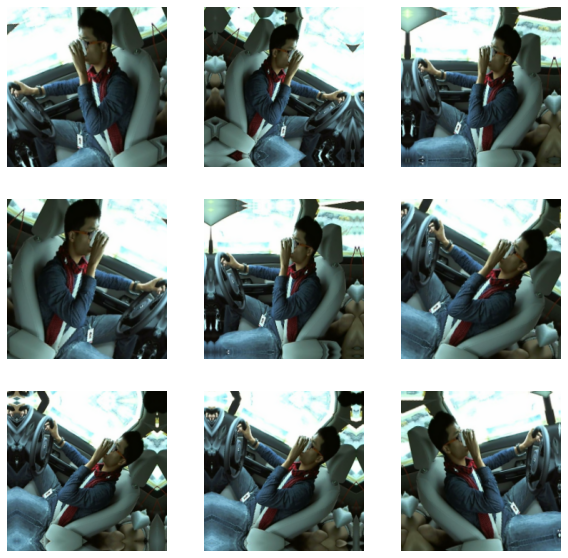

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_set.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#Utility Functions

We here define a function to better display the plots of accuracy and loss of our models.

In [ ]:
def plot_metrics(history):         
  metrics = ['loss', 'accuracy']
  plt.figure(figsize=(12,10))

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.grid()

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()

  return plt

Function to test the perfomances of a given model over the *test set*

In [ ]:
def evaluate_model_on_test(model):

  test_set = image_dataset_from_directory(
  '/gdrive/MyDrive/Progetto Computational Intelligence/test/10-class',
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
  shuffle = False)

  # test set true labels
  _, true_labels, _ = dataset_utils.index_directory('/gdrive/MyDrive/Progetto Computational Intelligence/test/10-class', labels='inferred', formats='.jpg', shuffle=False)

  predicted_labels = model.predict(test_set)
  predicted_labels = np.argmax(predicted_labels, axis=1) # for each test sample, consider the class with the highest probability

  # print metrics
  results=model.evaluate(test_set)
  print("Loss: " + str(results[0]))
  print("Accuracy: " + str(results[1]))
  print("Precision: " + str(precision_score(true_labels, predicted_labels , average="macro")))
  print("Recall: " + str(recall_score(true_labels, predicted_labels , average="macro")))
  print("F1-Score: " + str(f1_score(true_labels, predicted_labels , average="macro")))

  # plot the confusion matrix
  fig, ax = plt.subplots(figsize=(10, 10))
  ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels, xticks_rotation='vertical', ax=ax)

Function to evaluate the performances of the ensembling on the test set

In [ ]:
def evaluate_ensembling(predicted_labels_ensembled):
  # test set true labels
  _, true_labels, _ = dataset_utils.index_directory('/gdrive/MyDrive/Progetto Computational Intelligence/test/10-class', labels='inferred', formats='.jpg', shuffle=False)

  # print metrics
  print("Accuracy: " + str(accuracy_score(true_labels, predicted_labels_ensembled)))
  print("Precision: " + str(precision_score(true_labels, predicted_labels_ensembled , average="macro")))
  print("Recall: " + str(recall_score(true_labels, predicted_labels_ensembled , average="macro")))
  print("F1-Score: " + str(f1_score(true_labels, predicted_labels_ensembled , average="macro")))

  # plot the confusion matrix
  fig, ax = plt.subplots(figsize=(10, 10))
  ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels_ensembled, xticks_rotation='vertical', ax=ax)

# CNN from scratch

We now create our CNN model from scratch.

In [ ]:
def create_scratch_model(augment = False):                            
    inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    if augment:
      x = data_augmentation(inputs)
    else:
      x = inputs
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(loss='sparse_categorical_crossentropy',
      optimizer='rmsprop',
      metrics=['accuracy'])
  
    return model

Perform the k-fold cross-validation

In [ ]:
k_fold_train(create_scratch_model, 10, 10)

Fit the model on the overall training set

Epoch 1/10
96/96 [==============================] - 25s 241ms/step - loss: 1.7935 - accuracy: 0.3868 - val_loss: 0.6810 - val_accuracy: 0.7670
Epoch 2/10
96/96 [==============================] - 24s 237ms/step - loss: 0.4110 - accuracy: 0.8704 - val_loss: 0.2150 - val_accuracy: 0.9470
Epoch 3/10
96/96 [==============================] - 24s 237ms/step - loss: 0.1540 - accuracy: 0.9547 - val_loss: 0.1544 - val_accuracy: 0.9640
Epoch 4/10
96/96 [==============================] - 24s 236ms/step - loss: 0.0722 - accuracy: 0.9791 - val_loss: 0.1611 - val_accuracy: 0.9647
Epoch 5/10
96/96 [==============================] - 29s 290ms/step - loss: 0.0433 - accuracy: 0.9884 - val_loss: 0.1572 - val_accuracy: 0.9725
Epoch 6/10
96/96 [==============================] - 29s 285ms/step - loss: 0.0250 - accuracy: 0.9930 - val_loss: 0.2167 - val_accuracy: 0.9509
Epoch 7/10
96/96 [==============================] - 34s 334ms/step - loss: 0.0145 - accuracy: 0.9957 - val_loss: 0.1508 - val_accuracy: 0.9784

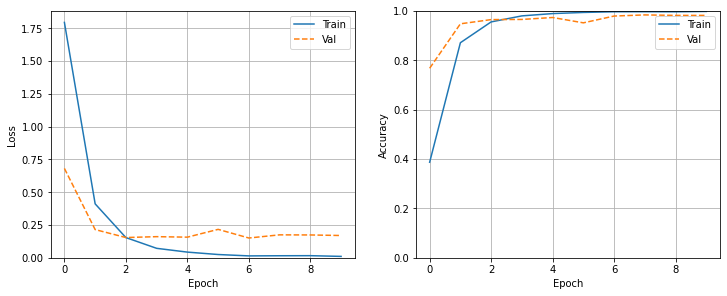

In [ ]:
model = create_scratch_model()
history = model.fit(train_set, epochs = 10,validation_data=validation_set)  # simple hold-out validation
plot_metrics(history).show()
model.save("/gdrive/MyDrive/Progetto Computational Intelligence/models/10-class/scratch_CNN.h5")

We test the performances on the test set

Found 1920 files belonging to 10 classes.
Found 1920 files belonging to 10 classes.
30/30 [==============================] - 5s 153ms/step - loss: 0.1399 - accuracy: 0.9807
Loss: 0.13990025222301483
Accuracy: 0.9807291626930237
Precision: 0.9809393021617911
Recall: 0.9807291666666667
F1-Score: 0.9807303679744394


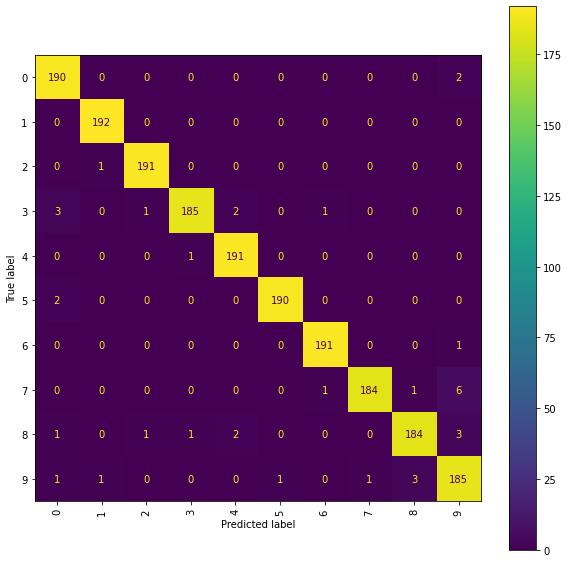

In [ ]:
evaluate_model_on_test(model)


# Pretrained CCNs: Xception

First let's take the Xception pretrained network adding a new dense classifier at the bottom

In [ ]:
xception = tf.keras.applications.Xception(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
    weights='imagenet', 
    include_top=False, 
  )
xception.summary()

Function to define a model based on the xception convolutional layers, adding a dense classifier at the bottom

In [ ]:
def create_xception_model(trainable=False, starting_block_name='', augment=False):    
  
#trainable is set to True if we want to train the last blocks of the pretrained network, 
#starting from the one specified in starting_block_name 

  pretrained_model = tf.keras.applications.Xception(
      input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
      weights='imagenet', 
      include_top=False,
    )
  
  inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
  if trainable:
    pretrained_model.trainable = True

    set_trainable = False
    for layer in pretrained_model.layers:
        if layer.name == starting_block_name:
            set_trainable = True
        layer.trainable = set_trainable
  else:                                     #if we don't specify it the pretrained model is set to trainable by default
    pretrained_model.trainable = False     

  if augment==True:
    x = data_augmentation(inputs)
  else:
    x=inputs
  x = keras.applications.xception.preprocess_input(x)   #preprocessing step for the Xception model
  x = pretrained_model(x)
  x=layers.Flatten()(x)
  x=layers.Dense(256, activation='relu')(x)
  outputs = layers.Dense(10, activation="softmax")(x)
  model = keras.Model(inputs, outputs)
  
  model.compile(loss="sparse_categorical_crossentropy",
                optimizer="rmsprop",
                metrics=["accuracy"])

  return model

We used a pretrained network such as Xception to perform classification. Initially we simply added 2 dense layers on top of the pretrained model, without setting any of the layers of the pretrained model to "trainable". 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               256903

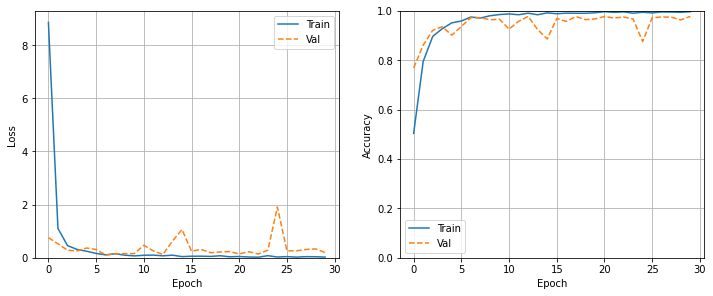

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
model = create_xception_model()
model.summary()
history = model.fit(train_set, epochs = 30,validation_data=validation_set)  
plot_metrics(history).show()
model.save("/gdrive/MyDrive/Progetto Computational Intelligence/models/10-class/xception_CNN_30epoche.h5")

Found 1920 files belonging to 10 classes.
Found 1920 files belonging to 10 classes.
30/30 [==============================] - 18s 610ms/step - loss: 0.2697 - accuracy: 0.9740
Loss: 0.2696862816810608
Accuracy: 0.9739583134651184
Precision: 0.9740442447509036
Recall: 0.9739583333333334
F1-Score: 0.9739488246727799


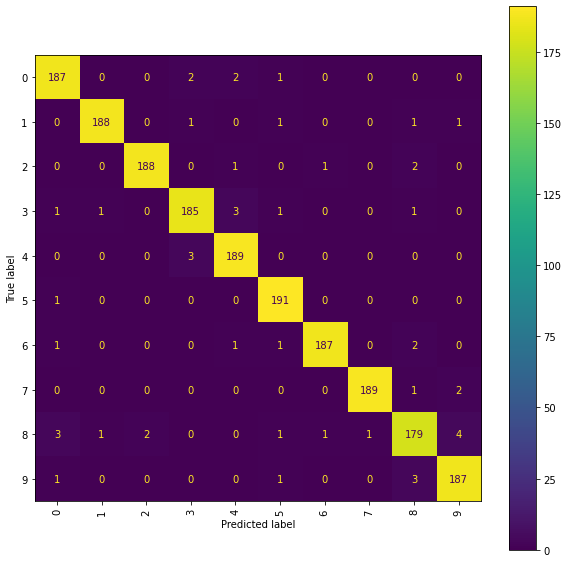

In [ ]:
evaluate_model_on_test(model)

Given the poor results obtained so far with the pretrained model, we decided to set the last block of the pretrained network as "trainable".  This may add more accuracy , adapting the model to the task

In [ ]:
model = create_xception_model(True, "block14_sepconv2")
model.summary()
history = model.fit(train_set, epochs = 30,validation_data=validation_set)  # simple hold-out validation
model.save("/gdrive/MyDrive/Progetto Computational Intelligence/models/10-class/xception_not_freezed_layers_30epoche.h5")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               2569

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


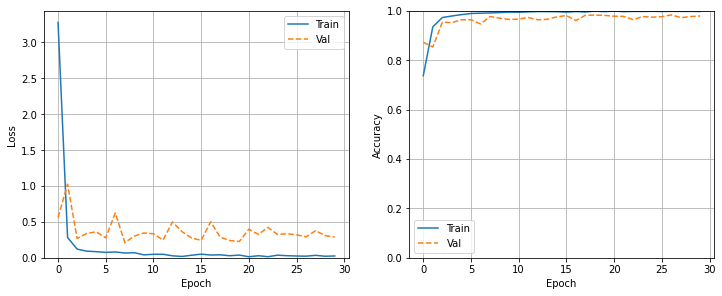

In [ ]:
plot_metrics(history).show()

Found 1920 files belonging to 10 classes.
Found 1920 files belonging to 10 classes.
30/30 [==============================] - 18s 609ms/step - loss: 0.3161 - accuracy: 0.9776
Loss: 0.3160895109176636
Accuracy: 0.9776041507720947
Precision: 0.9777691893832168
Recall: 0.9776041666666668
F1-Score: 0.9776213730076633


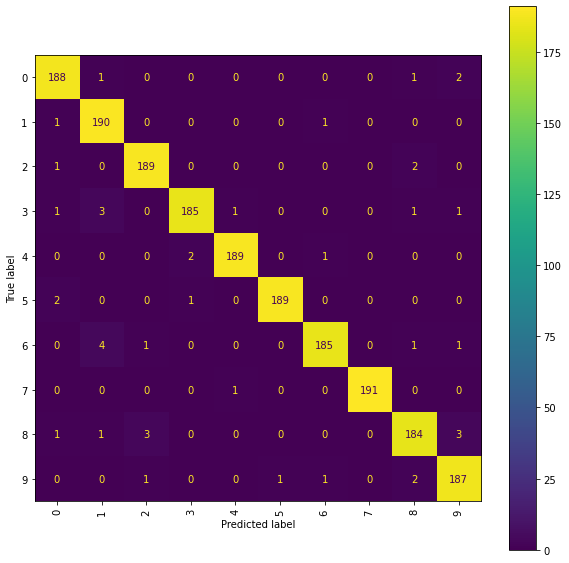

In [ ]:
evaluate_model_on_test(model)

#Pretrained CNNs: Resnet

We can have a look at another pretrained network

In [ ]:
resnet = tf.keras.applications.ResNet50(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
    weights='imagenet', 
    include_top=False,      #we just want to take the convolutional base, not the dense classifier
  )
resnet.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
def create_resnet_model(trainable=False, starting_block_name='', augment=False):    

#trainable is set to True if we want to train the last blocks of the pretrained network, 
#starting from the one specified in starting_block_name 

  pretrained_model = tf.keras.applications.ResNet50(
      input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
      weights='imagenet', 
      include_top=False,
    )
  
  inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
  if trainable:
    pretrained_model.trainable = True

    set_trainable = False
    for layer in pretrained_model.layers:
        if layer.name == starting_block_name:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
  else:                                 
    pretrained_model.trainable = False 
    
  if augment==True:
    x = data_augmentation(inputs)
  else:
    x=inputs
  x = keras.applications.resnet50.preprocess_input(x)
  x = pretrained_model(x)
  x=layers.Flatten()(x)
  x=layers.Dense(256, activation='relu')(x)
  outputs = layers.Dense(10, activation="softmax")(x)
  model = keras.Model(inputs, outputs)
  
  model.compile(loss="sparse_categorical_crossentropy",
                optimizer="rmsprop",
                metrics=["accuracy"])

  return model

We first freeze all the convolutional layers

Epoch 1/30
96/96 [==============================] - 65s 593ms/step - loss: 27.3130 - accuracy: 0.6209 - val_loss: 3.9026 - val_accuracy: 0.7965
Epoch 2/30
96/96 [==============================] - 53s 545ms/step - loss: 1.8125 - accuracy: 0.8986 - val_loss: 1.8941 - val_accuracy: 0.8599
Epoch 3/30
96/96 [==============================] - 53s 543ms/step - loss: 1.3091 - accuracy: 0.9277 - val_loss: 0.7734 - val_accuracy: 0.9260
Epoch 4/30
96/96 [==============================] - 53s 542ms/step - loss: 0.5668 - accuracy: 0.9604 - val_loss: 0.4355 - val_accuracy: 0.9686
Epoch 5/30
96/96 [==============================] - 53s 542ms/step - loss: 0.4854 - accuracy: 0.9668 - val_loss: 0.2524 - val_accuracy: 0.9738
Epoch 6/30
96/96 [==============================] - 53s 543ms/step - loss: 0.3590 - accuracy: 0.9759 - val_loss: 0.6228 - val_accuracy: 0.9535
Epoch 7/30
96/96 [==============================] - 53s 542ms/step - loss: 0.3770 - accuracy: 0.9792 - val_loss: 0.5369 - val_accuracy: 0.964

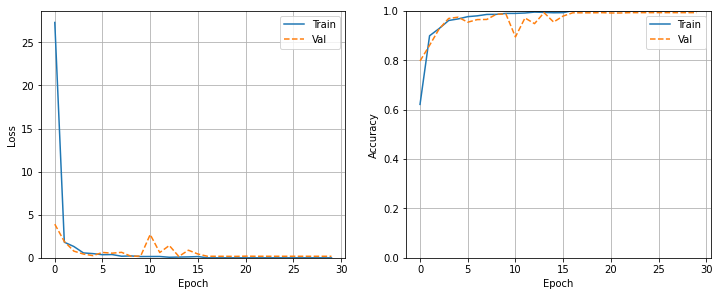

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
model = create_resnet_model()
history = model.fit(train_set, epochs = 30,validation_data=validation_set)  # simple hold-out validation
plot_metrics(history).show()
model.save("/gdrive/MyDrive/Progetto Computational Intelligence/models/10-class/resnet_CNN_30epoche.h5")

Found 1920 files belonging to 10 classes.
Found 1920 files belonging to 10 classes.
30/30 [==============================] - 13s 422ms/step - loss: 0.2811 - accuracy: 0.9906
Loss: 0.2810822129249573
Accuracy: 0.9906250238418579
Precision: 0.9906903591407479
Recall: 0.990625
F1-Score: 0.9906215609148802


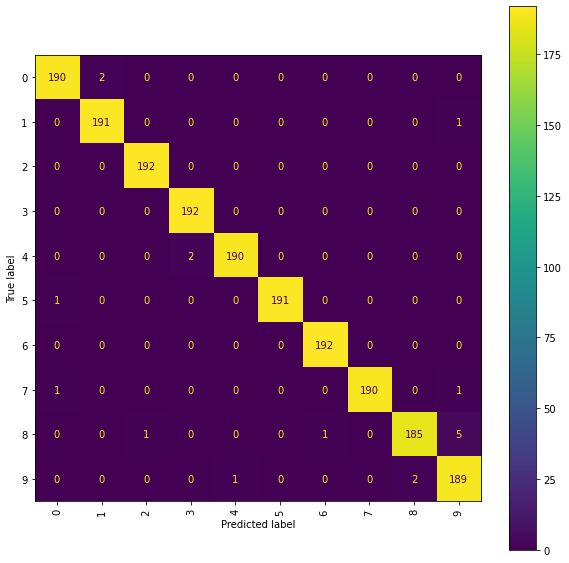

In [ ]:
evaluate_model_on_test(model)

Let's try to train also some of the convolutional layers. Firstly we unfreeze just the last block

In [ ]:
model = create_resnet_model(True, "conv5_block3_3_conv")
model.summary()
history = model.fit(train_set, epochs = 10,validation_data=validation_set)  # simple hold-out validation
model.save("/gdrive/MyDrive/Progetto Computational Intelligence/models/10-class/resnet_not_freezed_1_layers.h5")

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_7 (Flatten)         (None, 100352)            0         
                                                                 
 dense_12 (Dense)            (None, 256)               2569

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


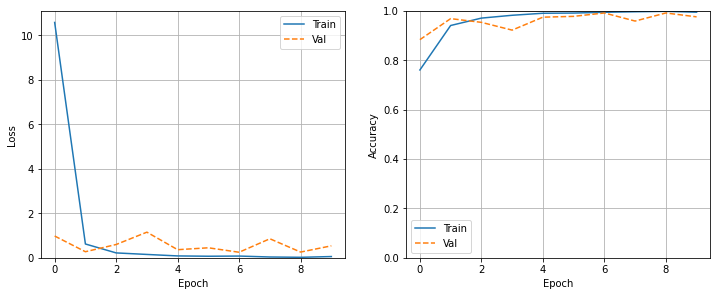

In [ ]:
plot_metrics(history).show()

Found 1920 files belonging to 10 classes.
Found 1920 files belonging to 10 classes.
30/30 [==============================] - 12s 392ms/step - loss: 0.3403 - accuracy: 0.9807
Loss: 0.3403283357620239
Accuracy: 0.9807291626930237
Precision: 0.9814910957856045
Recall: 0.9807291666666668
F1-Score: 0.9808337882749216


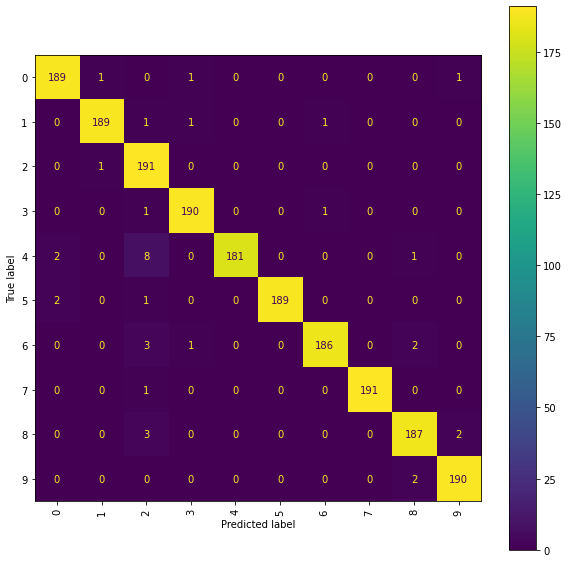

In [ ]:
evaluate_model_on_test(model)

#Pretrained CNNs: VGG16

In [ ]:
vgg16 = tf.keras.applications.vgg16.VGG16(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
    weights='imagenet', 
    include_top=False, 
  )
vgg16.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
def create_vgg16_model(trainable=False, starting_block_name='', augment=False):    

#trainable is set to True if we want to train the last blocks of the pretrained network, 
#starting from the one specified in starting_block_name 

  pretrained_model = tf.keras.applications.vgg16.VGG16(
      input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
      weights='imagenet', 
      include_top=False, 
    )
  
  inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
  if trainable:
    pretrained_model.trainable = True

    set_trainable = False
    for layer in pretrained_model.layers:
        if layer.name == starting_block_name:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
  else:
    pretrained_model.trainable = False 

  if augment==True:
    x = data_augmentation(inputs)
  else:
    x=inputs
    
  x = keras.applications.vgg16.preprocess_input(x)
  x = pretrained_model(x)
  x=layers.Flatten()(x)
  x=layers.Dense(256, activation='relu')(x)
  outputs = layers.Dense(10, activation="softmax")(x)
  model = keras.Model(inputs, outputs)
  
  model.compile(loss="sparse_categorical_crossentropy",
                optimizer="rmsprop",
                metrics=["accuracy"])

  return model

In [ ]:
model = create_vgg16_model()
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                                                                 
 dense_14 (Dense)            (None, 256)               6422

Epoch 1/10
96/96 [==============================] - 97s 835ms/step - loss: 22.0314 - accuracy: 0.7246 - val_loss: 4.4035 - val_accuracy: 0.8364
Epoch 2/10
96/96 [==============================] - 57s 588ms/step - loss: 1.3056 - accuracy: 0.9347 - val_loss: 4.8503 - val_accuracy: 0.8331
Epoch 3/10
96/96 [==============================] - 57s 581ms/step - loss: 0.8754 - accuracy: 0.9566 - val_loss: 0.7414 - val_accuracy: 0.9705
Epoch 4/10
96/96 [==============================] - 57s 582ms/step - loss: 0.5501 - accuracy: 0.9728 - val_loss: 1.9914 - val_accuracy: 0.9359
Epoch 5/10
96/96 [==============================] - 57s 581ms/step - loss: 0.4481 - accuracy: 0.9795 - val_loss: 1.1494 - val_accuracy: 0.9686
Epoch 6/10
96/96 [==============================] - 57s 579ms/step - loss: 0.3450 - accuracy: 0.9841 - val_loss: 0.7914 - val_accuracy: 0.9764
Epoch 7/10
96/96 [==============================] - 57s 579ms/step - loss: 0.3135 - accuracy: 0.9841 - val_loss: 0.6369 - val_accuracy: 0.984

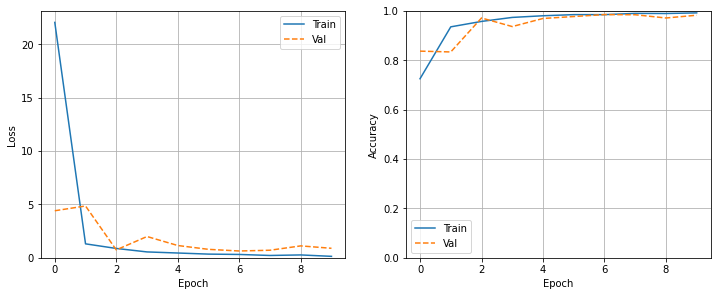

In [ ]:
history = model.fit(train_set, epochs = 10,validation_data=validation_set) 
plot_metrics(history).show()
model.save("/gdrive/MyDrive/Progetto Computational Intelligence/models/10-class/vgg16_CNN.h5")

Found 1920 files belonging to 10 classes.
Found 1920 files belonging to 10 classes.
30/30 [==============================] - 14s 463ms/step - loss: 0.5765 - accuracy: 0.9849
Loss: 0.5765126347541809
Accuracy: 0.9848958253860474
Precision: 0.9851682970596725
Recall: 0.9848958333333332
F1-Score: 0.984891844725216


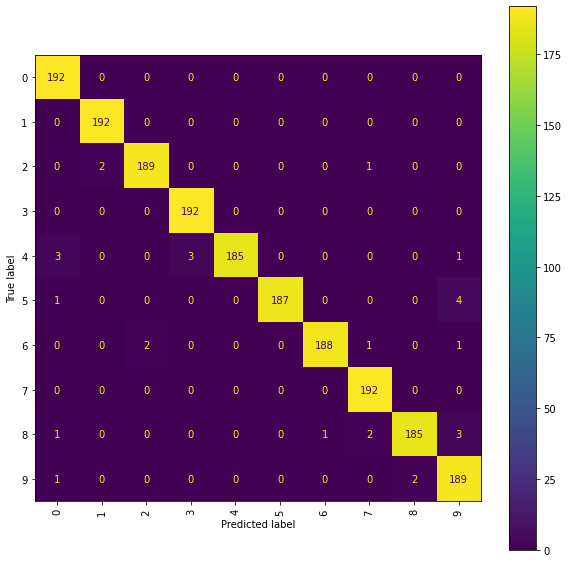

In [ ]:
evaluate_model_on_test(model)

Let's try to unfreeze the last 3 layers of the pretrained model.

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 25088)             0         
                                                                 
 dense_16 (Dense)            (None, 256)               6422

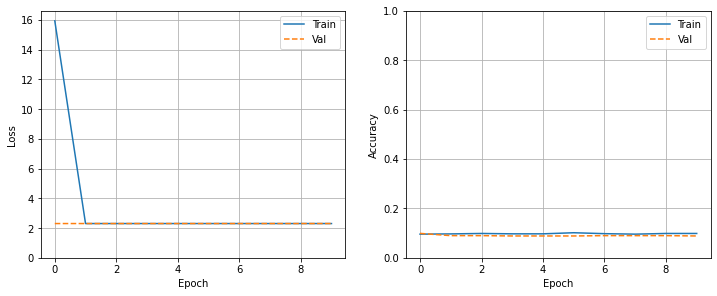

In [ ]:
model = create_vgg16_model(True, "block5_conv1")
model.summary()
history = model.fit(train_set, epochs = 10,validation_data=validation_set)  # simple hold-out validation
plot_metrics(history).show()
model.save("/gdrive/MyDrive/Progetto Computational Intelligence/models/10-class/vgg16_not_freezed_3_layers.h5")

Found 1920 files belonging to 10 classes.
Found 1920 files belonging to 10 classes.
30/30 [==============================] - 14s 463ms/step - loss: 2.3027 - accuracy: 0.1000
Loss: 2.3027100563049316
Accuracy: 0.10000000149011612
Precision: 0.01
Recall: 0.1
F1-Score: 0.01818181818181818


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


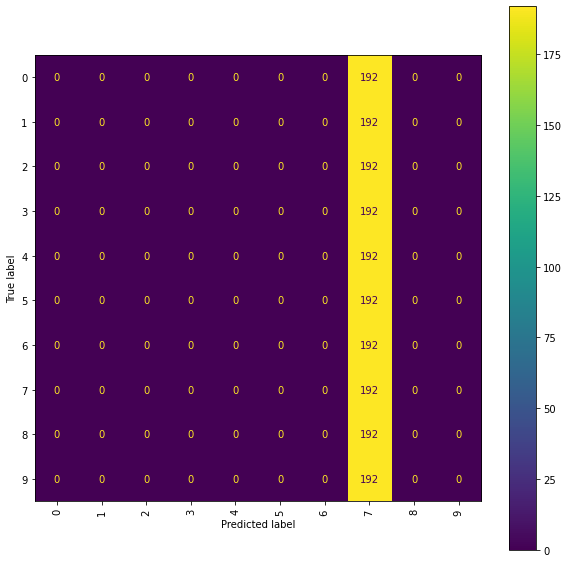

In [ ]:
evaluate_model_on_test(model)

Given the poor results of the previous model, let's try to unfreeze the only the last layer of the pretrained model.

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 25088)             0         
                                                                 
 dense_18 (Dense)            (None, 256)               642

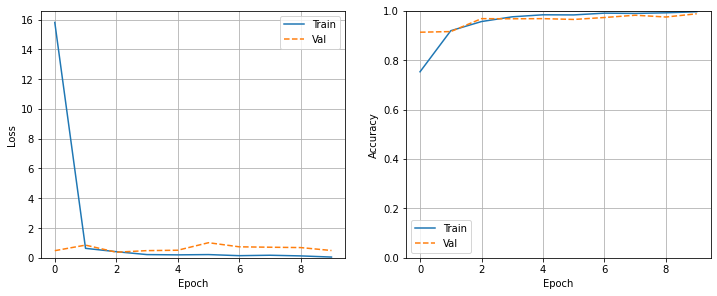

In [ ]:
model = create_vgg16_model(True, "block5_conv3")
model.summary()
history = model.fit(train_set, epochs = 10,validation_data=validation_set)  # simple hold-out validation
plot_metrics(history).show()
model.save("/gdrive/MyDrive/Progetto Computational Intelligence/models/10-class/vgg16_not_freezed_1_layer.h5")

Found 1920 files belonging to 10 classes.
Found 1920 files belonging to 10 classes.
30/30 [==============================] - 14s 467ms/step - loss: 0.3407 - accuracy: 0.9823
Loss: 0.3406538963317871
Accuracy: 0.9822916388511658
Precision: 0.9825312945102865
Recall: 0.9822916666666668
F1-Score: 0.9822248521358962


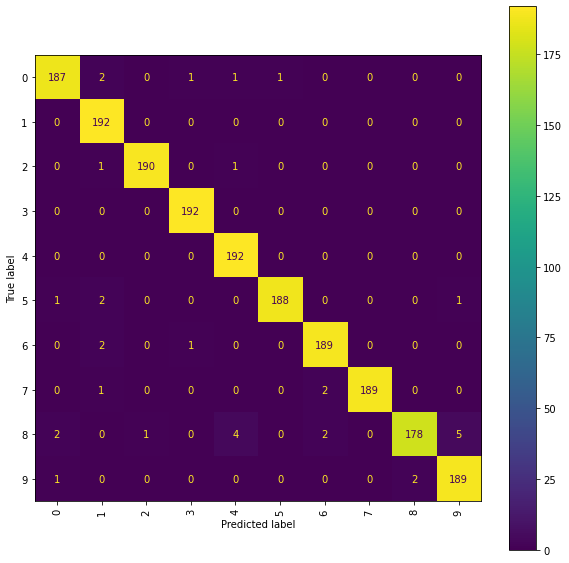

In [ ]:
evaluate_model_on_test(model)

# Data augmentation

We have already added an option to include augmentation. Now we build models applying it

Epoch 1/50
96/96 [==============================] - 41s 278ms/step - loss: 2.3391 - accuracy: 0.1353 - val_loss: 2.1015 - val_accuracy: 0.2690
Epoch 2/50
96/96 [==============================] - 26s 259ms/step - loss: 1.8382 - accuracy: 0.3578 - val_loss: 1.6046 - val_accuracy: 0.4175
Epoch 3/50
96/96 [==============================] - 25s 252ms/step - loss: 1.4487 - accuracy: 0.4954 - val_loss: 1.1804 - val_accuracy: 0.6080
Epoch 4/50
96/96 [==============================] - 25s 252ms/step - loss: 1.1823 - accuracy: 0.5991 - val_loss: 1.0261 - val_accuracy: 0.6787
Epoch 5/50
96/96 [==============================] - 25s 250ms/step - loss: 0.9846 - accuracy: 0.6669 - val_loss: 1.1542 - val_accuracy: 0.6603
Epoch 6/50
96/96 [==============================] - 25s 249ms/step - loss: 0.7932 - accuracy: 0.7420 - val_loss: 0.9371 - val_accuracy: 0.7297
Epoch 7/50
96/96 [==============================] - 25s 249ms/step - loss: 0.6508 - accuracy: 0.7891 - val_loss: 0.5685 - val_accuracy: 0.8370

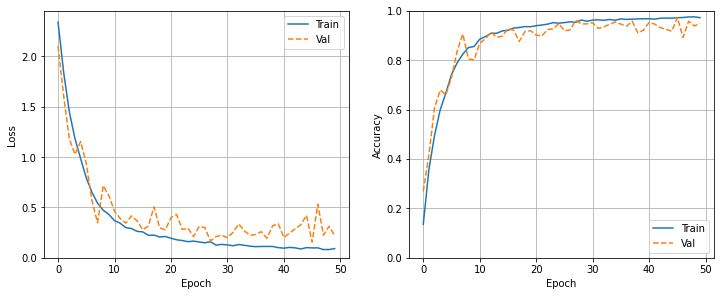

In [ ]:
model = create_scratch_model(augment=True)
history = model.fit(train_set, epochs = 50,validation_data=validation_set)  
plot_metrics(history).show()
model.save("/gdrive/MyDrive/Progetto Computational Intelligence/models/10-class/augmented_scratch_50epoche.h5")

We test the performances on the test set

Found 1920 files belonging to 10 classes.
Found 1920 files belonging to 10 classes.
30/30 [==============================] - 8s 273ms/step - loss: 0.2432 - accuracy: 0.9500
Loss: 0.2432439923286438
Accuracy: 0.949999988079071
Precision: 0.9518535796921077
Recall: 0.95
F1-Score: 0.949993968834093


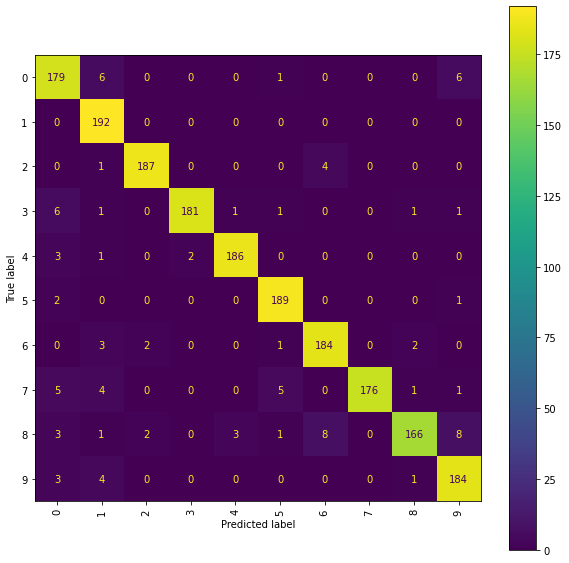

In [ ]:
evaluate_model_on_test(model)

Then we evaluate augmented pretrained models `without any Fine-Tuning`, starting with Xception...

In [ ]:
model = create_xception_model(augment=True)
history = model.fit(train_set, epochs = 70,validation_data=validation_set)
model.save("/gdrive/MyDrive/Progetto Computational Intelligence/models/10-class/augmented_xception_70epoche.h5")

83697664/83683744 [==============================] - 1s 0us/step
Epoch 1/70
96/96 [==============================] - 91s 790ms/step - loss: 13.5101 - accuracy: 0.2243 - val_loss: 2.0084 - val_accuracy: 0.2880
Epoch 2/70
96/96 [==============================] - 73s 754ms/step - loss: 1.9900 - accuracy: 0.3069 - val_loss: 1.4197 - val_accuracy: 0.4758
Epoch 3/70
96/96 [==============================] - 73s 755ms/step - loss: 1.6294 - accuracy: 0.4138 - val_loss: 2.1911 - val_accuracy: 0.3423
Epoch 4/70
96/96 [==============================] - 73s 755ms/step - loss: 1.4197 - accuracy: 0.4910 - val_loss: 1.3175 - val_accuracy: 0.5164
Epoch 5/70
96/96 [==============================] - 74s 756ms/step - loss: 1.2683 - accuracy: 0.5501 - val_loss: 1.3127 - val_accuracy: 0.5733
Epoch 6/70
96/96 [==============================] - 73s 755ms/step - loss: 1.0939 - accuracy: 0.6126 - val_loss: 1.2005 - val_accuracy: 0.5792
Epoch 7/70
96/96 [==============================] - 74s 756ms/step - loss: 1

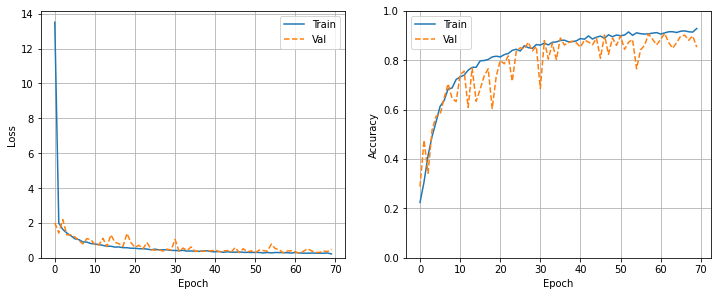

In [ ]:
plot_metrics(history).show()

Found 1920 files belonging to 10 classes.
Found 1920 files belonging to 10 classes.
30/30 [==============================] - 17s 577ms/step - loss: 0.5020 - accuracy: 0.8552
Loss: 0.502006471157074
Accuracy: 0.8552083373069763
Precision: 0.8865165613925854
Recall: 0.8552083333333332
F1-Score: 0.8541117142416604


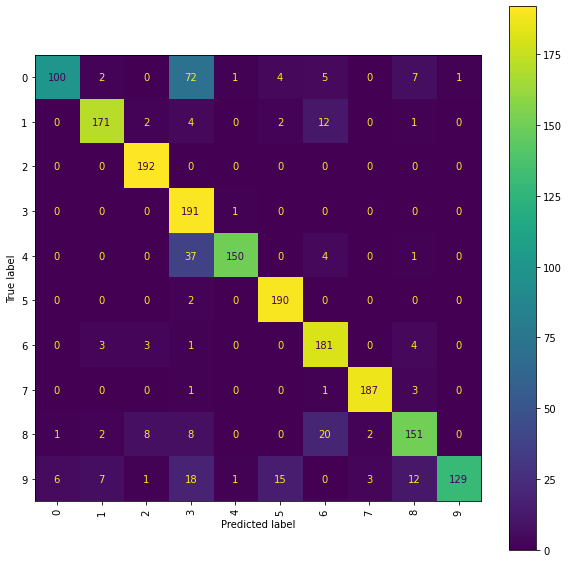

In [ ]:
evaluate_model_on_test(model)

...Resnet...

In [ ]:
model = create_resnet_model(augment=True)
history = model.fit(train_set, epochs = 50,validation_data=validation_set)  
plot_metrics(history).show()
model.save("/gdrive/MyDrive/Progetto Computational Intelligence/models/10-class/augmented_resnet_50epoche.h5")

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/50
96/96 [==============================] - 66s 616ms/step - loss: 27.5414 - accuracy: 0.2418 - val_loss: 9.0221 - val_accuracy: 0.3802
Epoch 2/50
96/96 [==============================] - 56s 569ms/step - loss: 3.7326 - accuracy: 0.4080 - val_loss: 2.3832 - val_accuracy: 0.3017
Epoch 3/50
96/96 [==============================] - 55s 565ms/step - loss: 2.0029 - accuracy: 0.3979 - val_loss: 1.7111 - val_accuracy: 0.5105
Epoch 4/50
96/96 [==============================] - 55s 561ms/step - loss: 1.4080 - accuracy: 0.5872 - val_loss: 1.7463 - val_accuracy: 0.5321
Epoch 5/50
96/96 [==============================] - 55s 560ms/step - loss: 1.1140 - accuracy: 0.6638 - val_loss: 0.9396 - val_accuracy: 0.7507
Epoch 6/50
96/96 [==============================] - 55s 562ms/step - loss: 0.9284 - accuracy: 0.7364 - val_loss: 0.8392 - val_accuracy: 0.7664
Epoch 7/50
96/96 [==============================] - 55s 562ms/step - loss: 0

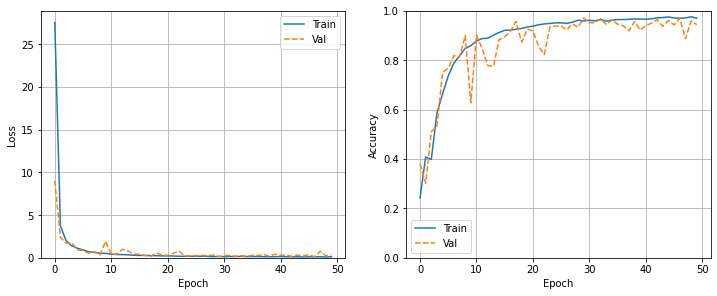

In [ ]:
plot_metrics(history).show()

Found 1920 files belonging to 10 classes.
Found 1920 files belonging to 10 classes.
30/30 [==============================] - 12s 400ms/step - loss: 0.3221 - accuracy: 0.9458
Loss: 0.32210999727249146
Accuracy: 0.9458333253860474
Precision: 0.9548715069116321
Recall: 0.9458333333333334
F1-Score: 0.9452888331304591


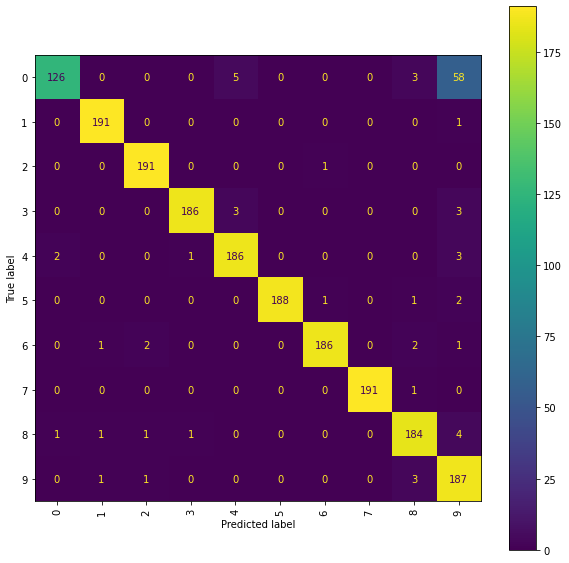

In [ ]:
evaluate_model_on_test(model)

... and finally VGG16

Epoch 1/30
96/96 [==============================] - 60s 602ms/step - loss: 18.9548 - accuracy: 0.3959 - val_loss: 5.7525 - val_accuracy: 0.5327
Epoch 2/30
96/96 [==============================] - 58s 598ms/step - loss: 2.4682 - accuracy: 0.6304 - val_loss: 1.5385 - val_accuracy: 0.7029
Epoch 3/30
96/96 [==============================] - 58s 599ms/step - loss: 1.5369 - accuracy: 0.7222 - val_loss: 1.0089 - val_accuracy: 0.8514
Epoch 4/30
96/96 [==============================] - 58s 597ms/step - loss: 0.8546 - accuracy: 0.8048 - val_loss: 0.6041 - val_accuracy: 0.8920
Epoch 5/30
96/96 [==============================] - 59s 598ms/step - loss: 0.6949 - accuracy: 0.8308 - val_loss: 0.7670 - val_accuracy: 0.8599
Epoch 6/30
96/96 [==============================] - 58s 598ms/step - loss: 0.5462 - accuracy: 0.8667 - val_loss: 0.4411 - val_accuracy: 0.9116
Epoch 7/30
96/96 [==============================] - 58s 598ms/step - loss: 0.4742 - accuracy: 0.8914 - val_loss: 0.5750 - val_accuracy: 0.904

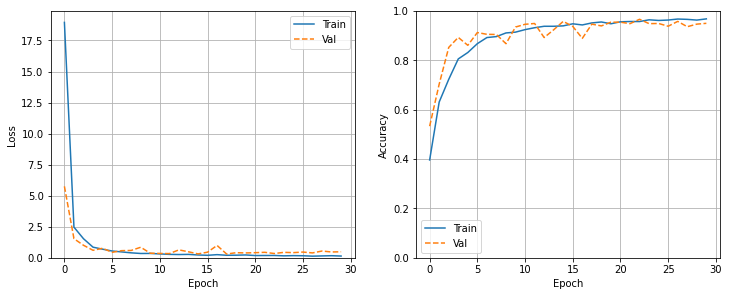

In [ ]:
model = create_vgg16_model(augment=True)
history = model.fit(train_set, epochs = 30,validation_data=validation_set)  
plot_metrics(history).show()
model.save("/gdrive/MyDrive/Progetto Computational Intelligence/models/10-class/augmented_vgg16_30epoche.h5")

Found 1920 files belonging to 10 classes.
Found 1920 files belonging to 10 classes.
30/30 [==============================] - 14s 459ms/step - loss: 0.4608 - accuracy: 0.9438
Loss: 0.460799902677536
Accuracy: 0.9437500238418579
Precision: 0.948602132742297
Recall: 0.94375
F1-Score: 0.9445455711092094


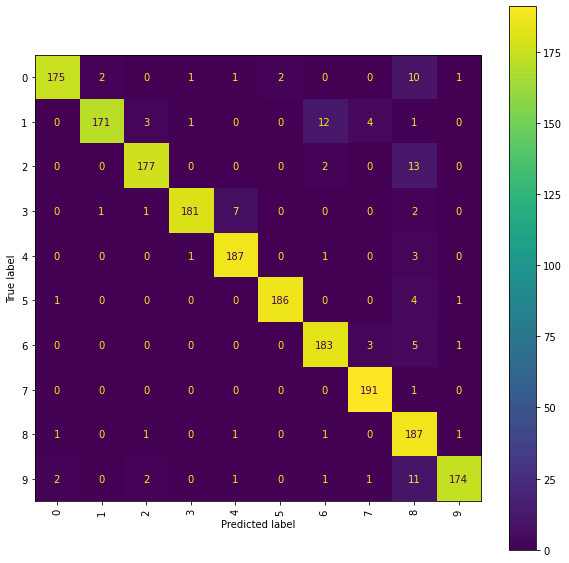

In [ ]:
evaluate_model_on_test(model)

# Ensembling

Load the two candidate models for the ensembling:


*   Scratch augmented 
*   Resnet augmented



In [ ]:
scratch_augmented = models.load_model("/gdrive/MyDrive/Progetto Computational Intelligence/models/10-class/augmented_scratch_50epoche.h5")
resnet_augmented = models.load_model("/gdrive/MyDrive/Progetto Computational Intelligence/models/10-class/augmented_resnet_50epoche.h5")

Load the test set

In [ ]:
test_set = image_dataset_from_directory(
  '/gdrive/MyDrive/Progetto Computational Intelligence/test/10-class',
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
  shuffle = False)

Found 1920 files belonging to 10 classes.


Predict the labels of the test set using both the **scratch_augmented** model and the **resnet_augmented** one

In [ ]:
prediction_scratch = scratch_augmented.predict(test_set)
prediction_resnet = resnet_augmented.predict(test_set)

We obtain the ensembled predictions considering the mean of the individual predictions of the two models

Found 1920 files belonging to 10 classes.
Accuracy: 0.9760416666666667
Precision: 0.9775042960950528
Recall: 0.9760416666666666
F1-Score: 0.9761364874063838


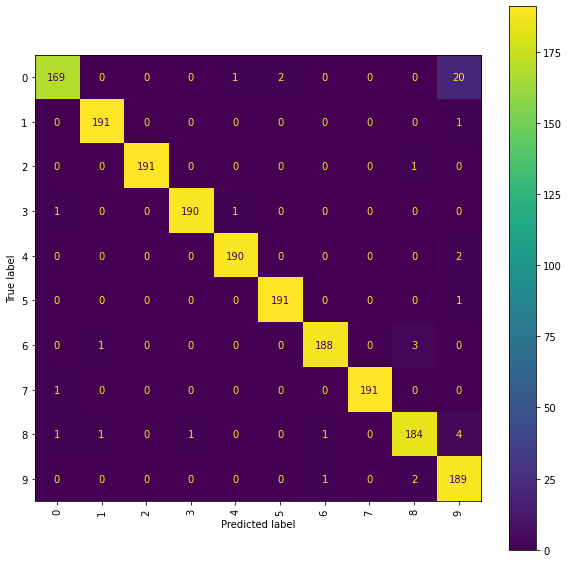

In [ ]:
ensembled_prediction = 0.50 * (prediction_scratch + prediction_resnet)
predicted_labels_ensembled = np.argmax(ensembled_prediction, axis=1) # for each test sample, consider the class with the highest probability
evaluate_ensembling(predicted_labels_ensembled)

Given that the predictions on class 0 still remains unsatisfactory, due to the Resnet model, we decided to give importance only to the predictions of the scratch model for that class. An analogue procedure has been carried out with the Resnet predictions for class 8.

Found 1920 files belonging to 10 classes.
Accuracy: 0.9765625
Precision: 0.9771711574827912
Recall: 0.9765625
F1-Score: 0.9767324455761879


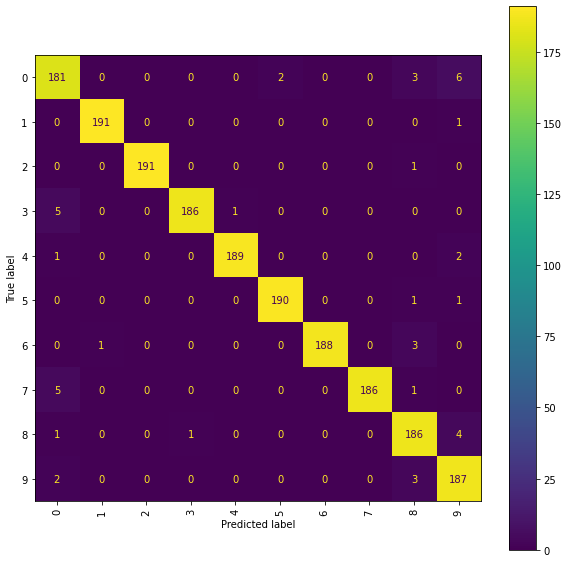

In [ ]:
predicted_labels_ensembled = np.argmax(ensembled_prediction, axis=1) # for each test sample, consider the class with the highest probability
predicted_labels_scratch = np.argmax(prediction_scratch, axis=1)
predicted_labels_resnet = np.argmax(prediction_resnet, axis=1)

for i in range(len(predicted_labels_scratch)):
  if predicted_labels_scratch[i] == 0:
    predicted_labels_ensembled[i] = 0
  if predicted_labels_resnet[i] == 8:
    predicted_labels_ensembled[i] = 8

evaluate_ensembling(predicted_labels_ensembled)